# 🌳 Modelo de Machine Learning para Predecir la Pobreza Monetaria en Perú (Gradient Boosting)

## 🎯 Objetivo de la Actividad
En este notebook, construiremos, entrenaremos y evaluaremos un modelo de **Gradient Boosting** para predecir si un hogar en Perú caerá en situación de pobreza monetaria. Utilizaremos una base de datos sintética que simula las características de los hogares peruanos.


### 🧠 Conceptos Clave que Aprenderemos:
- **Preprocesamiento de datos**: Cómo preparar variables categóricas y numéricas.
- **Pipelines en Scikit-learn**: Para organizar nuestro flujo de trabajo de forma profesional.
- **Entrenamiento de un clasificador**: Cómo enseñarle al modelo a partir de los datos.
- **Métricas de Evaluación**: No solo la exactitud (accuracy), sino también la **Precisión**, el **Recall** y la **Matriz de Confusión**.
- **Importancia de Variables (Feature Importance)**: Cómo el modelo nos "explica" su decisión.
- **Análisis SHAP**: Para una interpretabilidad más profunda.

## 📚 1. Definición del Problema y Preparación Inicial

In [1]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import warnings

# Para preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

# Para evaluar el modelo
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay

# Configuraciones adicionales
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Librerías importadas correctamente.")

✅ Librerías importadas correctamente.


In [2]:
# Nombre de la carpeta donde se guardarán las imágenes
folder_name = "imagenes"
os.makedirs(folder_name, exist_ok=True)
print(f"✅ Carpeta '{folder_name}' lista para guardar las imágenes.")

✅ Carpeta 'imagenes' lista para guardar las imágenes.


## 🛠️ 2. Preprocesamiento y Limpieza de Datos

In [3]:
# 2.1 Cargar e Inspeccionar los Datos
df = pd.read_csv('prediccion_pobreza_peru.csv')

print("Primeras 5 filas del dataset:")
display(df.head())

print("\nInformación general del DataFrame:")
df.info()

print(f"\nEl dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")
print("\nConteo de valores nulos por columna:")
print(df.isnull().sum())

Primeras 5 filas del dataset:


,EdadJefeHogar,SexoJefeHogar,MiembrosHogar,RatioDependencia,LenguaMaterna,NivelEducativoJefeHogar,TipoEmpleo,AreaResidencia,Region,AccesoAguaPotable,AccesoSaneamiento,Hacinamiento,PoseeActivos,TenenciaVivienda,MaterialParedes,AccesoElectricidad,AniosEstudioJefeHogar,IngresoMensualHogar,GastoMensualHogar,PobrezaMonetaria
0,20,Hombre,4,0.48,Español,Secundaria,Informal,Rural,Costa,1,1,1,1,Propia,Ladrillo/Cemento,1,10,735.00,746.73,1
1,45,Mujer,8,1.27,Español,Secundaria,Informal,Urbana,Costa,1,0,0,1,Propia,Ladrillo/Cemento,1,7,2568.16,2465.73,1
2,39,Mujer,4,0.12,Español,Superior,Desempleado,Rural,Costa,1,1,1,1,Propia,Ladrillo/Cemento,1,21,1474.71,1704.89,1
3,28,Mujer,3,2.85,Español,Ninguno,Formal,Urbana,Costa,1,1,1,0,Alquilada,Madera/Esteras,1,0,3420.87,2935.34,0
4,36,Hombre,7,1.90,Español,Superior,Informal,Rural,Selva,1,1,1,1,Propia,Adobe,1,14,922.37,676.64,1



Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EdadJefeHogar            2000 non-null   int64  
 1   SexoJefeHogar            2000 non-null   object 
 2   MiembrosHogar            2000 non-null   int64  
 3   RatioDependencia         2000 non-null   float64
 4   LenguaMaterna            2000 non-null   object 
 5   NivelEducativoJefeHogar  2000 non-null   object 
 6   TipoEmpleo               2000 non-null   object 
 7   AreaResidencia           2000 non-null   object 
 8   Region                   2000 non-null   object 
 9   AccesoAguaPotable        2000 non-null   int64  
 10  AccesoSaneamiento        2000 non-null   int64  
 11  Hacinamiento             2000 non-null   int64  
 12  PoseeActivos             2000 non-null   int64  
 13  TenenciaVivienda         2000 non-null   o

In [4]:
# 2.2 Separar variables predictoras (X) y objetivo (y)
X = df.drop(['PobrezaMonetaria', 'IngresoMensualHogar', 'GastoMensualHogar'], axis=1)
y = df['PobrezaMonetaria']

# 2.3 Identificar columnas numéricas y categóricas
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

print(f"\nColumnas Numéricas ({len(numerical_cols)}): {list(numerical_cols)}")
print(f"\nColumnas Categóricas ({len(categorical_cols)}): {list(categorical_cols)}")


Columnas Numéricas (9): ['EdadJefeHogar', 'MiembrosHogar', 'RatioDependencia', 'AccesoAguaPotable', 'AccesoSaneamiento', 'Hacinamiento', 'PoseeActivos', 'AccesoElectricidad', 'AniosEstudioJefeHogar']

Columnas Categóricas (8): ['SexoJefeHogar', 'LenguaMaterna', 'NivelEducativoJefeHogar', 'TipoEmpleo', 'AreaResidencia', 'Region', 'TenenciaVivienda', 'MaterialParedes']


## 3. División de los Datos (Entrenamiento y Prueba)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} hogares")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} hogares")

Tamaño del conjunto de entrenamiento: 1400 hogares
Tamaño del conjunto de prueba: 600 hogares


## 🤖 4. Construcción y Entrenamiento del Pipeline con Gradient Boosting

In [6]:
# Definimos los pasos de preprocesamiento
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Creamos el Pipeline final con el clasificador GradientBoostingClassifier
# El nombre 'classifier' se mantiene para que el GridSearchCV funcione sin cambios
pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Entrenamos el modelo base para una primera evaluación
print("🚀 Entrenando el modelo Gradient Boosting base...")
pipeline_final.fit(X_train, y_train)
print("✅ ¡Modelo base entrenado exitosamente!")

🚀 Entrenando el modelo Gradient Boosting base...
✅ ¡Modelo base entrenado exitosamente!


## 📊 5. Evaluación del Modelo Base

In [7]:
y_pred = pipeline_final.predict(X_test)
y_pred_proba = pipeline_final.predict_proba(X_test)[:, 1]

print("="*60)
print("Reporte de Clasificación (Modelo Base)")
print(classification_report(y_test, y_pred, target_names=['No Pobre (0)', 'Pobre (1)']))

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy (Exactitud): {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("="*60)

Reporte de Clasificación (Modelo Base)
              precision    recall  f1-score   support

No Pobre (0)       0.86      0.85      0.85       343
   Pobre (1)       0.80      0.81      0.81       257

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600

Accuracy (Exactitud): 0.8333
ROC-AUC Score: 0.9223


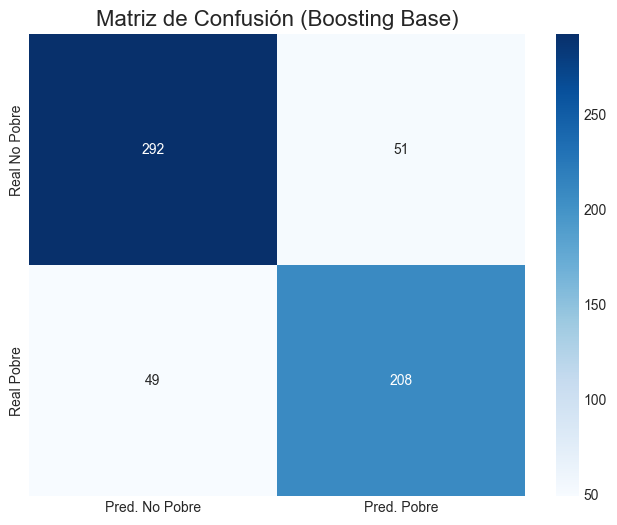

In [8]:
# Matriz de Confusión del modelo base
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred. No Pobre', 'Pred. Pobre'],
            yticklabels=['Real No Pobre', 'Real Pobre'])
plt.title('Matriz de Confusión (Boosting Base)', fontsize=16)
plt.savefig(os.path.join(folder_name, '1_matriz_confusion_base_boosting.png'))
plt.show()

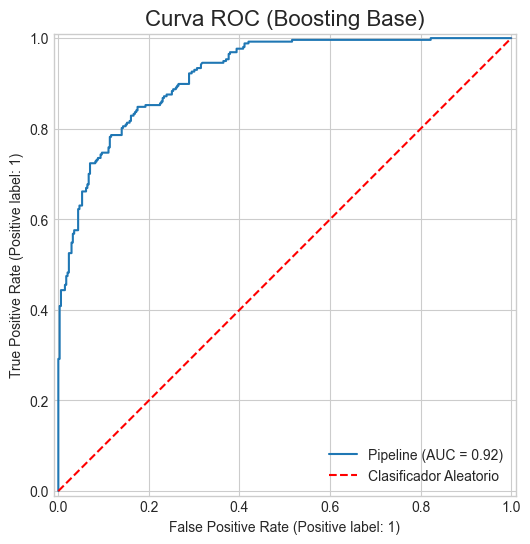

In [9]:
# Curva ROC del modelo base
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(pipeline_final, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Clasificador Aleatorio')
ax.set_title('Curva ROC (Boosting Base)', fontsize=16)
plt.legend()
plt.savefig(os.path.join(folder_name, '2_curva_roc_base_boosting.png'))
plt.show()

## ⚙️ 6. Optimización de Hiperparámetros con GridSearchCV

In [10]:
# 1. Definición de la rejilla de hiperparámetros para Gradient Boosting
param_grid = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}

# 2. Configurar y ejecutar GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_final,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("🚀 Ejecutando GridSearchCV para Gradient Boosting...")
grid_search.fit(X_train, y_train)

# 3. Mostrar los resultados
print("\n✅ Búsqueda completada.")
print("La mejor configuración de hiperparámetros es:")
print(grid_search.best_params_)

🚀 Ejecutando GridSearchCV para Gradient Boosting...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

✅ Búsqueda completada.
La mejor configuración de hiperparámetros es:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}


### 📊 Visualización de Resultados de GridSearchCV

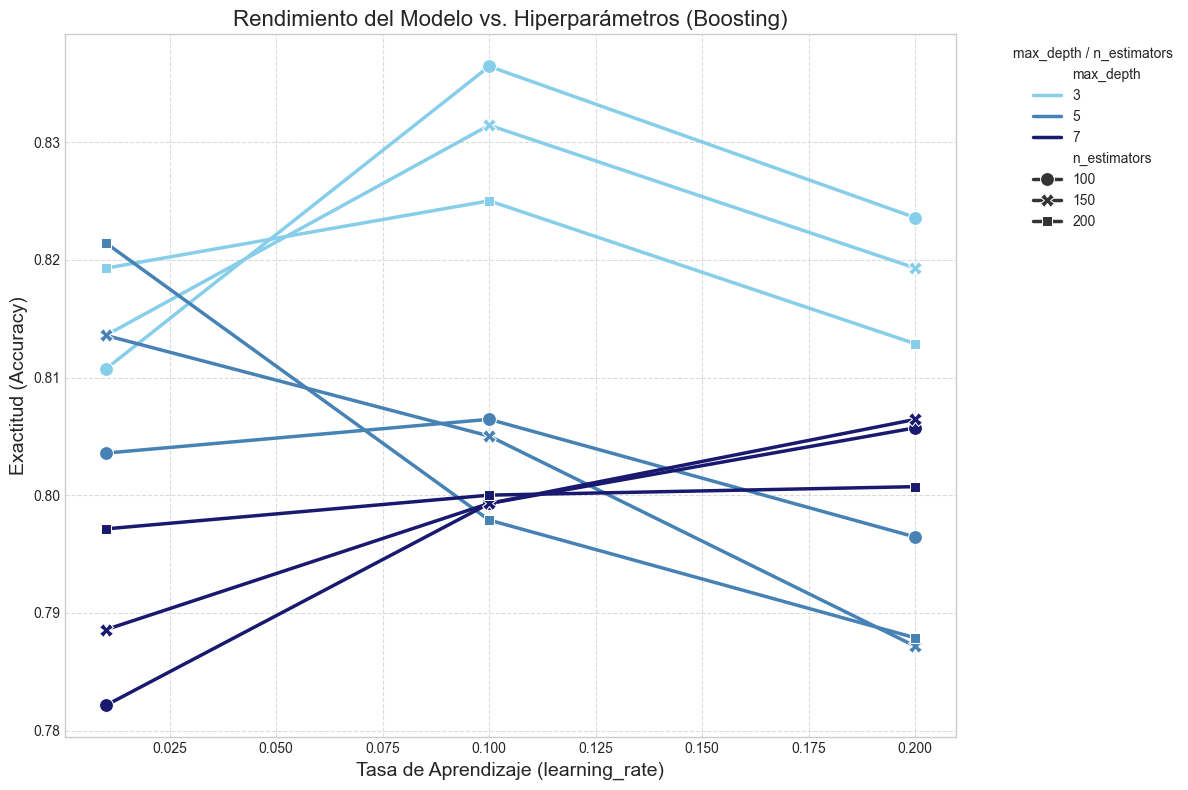

In [11]:
# Paleta de colores para el gráfico
azules = ["#87CEEB", "#4682B4", "#191970"]

# Extraer resultados
results = pd.DataFrame(grid_search.cv_results_)
plot_data = pd.DataFrame({
    'learning_rate': results['param_classifier__learning_rate'],
    'Accuracy': results['mean_test_score'],
    'max_depth': results['param_classifier__max_depth'],
    'n_estimators': results['param_classifier__n_estimators']
})

# Crear el gráfico
plt.figure(figsize=(12, 8))
ax = sns.lineplot(
    data=plot_data,
    x='learning_rate',
    y='Accuracy',
    hue='max_depth',
    style='n_estimators',
    markers=True,
    dashes=False,
    palette=azules,
    markersize=10,
    linewidth=2.5
)

# Configurar gráfico
plt.xlabel('Tasa de Aprendizaje (learning_rate)', fontsize=14)
plt.ylabel('Exactitud (Accuracy)', fontsize=14)
plt.title('Rendimiento del Modelo vs. Hiperparámetros (Boosting)', fontsize=16)
ax.legend(title='max_depth / n_estimators', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(folder_name, '7_gridsearch_results_boosting.png'), dpi=300)
plt.show()

## ✨ 7. Evaluación del Modelo Optimizado

In [12]:
# Extraer y evaluar el mejor modelo
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("Rendimiento del Modelo Optimizado (Boosting)")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=['No Pobre (0)', 'Pobre (1)']))

accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)
print(f"Accuracy (Exactitud): {accuracy_best:.4f}")
print(f"ROC-AUC Score: {roc_auc_best:.4f}")
print("="*60)


Rendimiento del Modelo Optimizado (Boosting)
              precision    recall  f1-score   support

No Pobre (0)       0.86      0.85      0.85       343
   Pobre (1)       0.80      0.81      0.81       257

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600

Accuracy (Exactitud): 0.8333
ROC-AUC Score: 0.9223


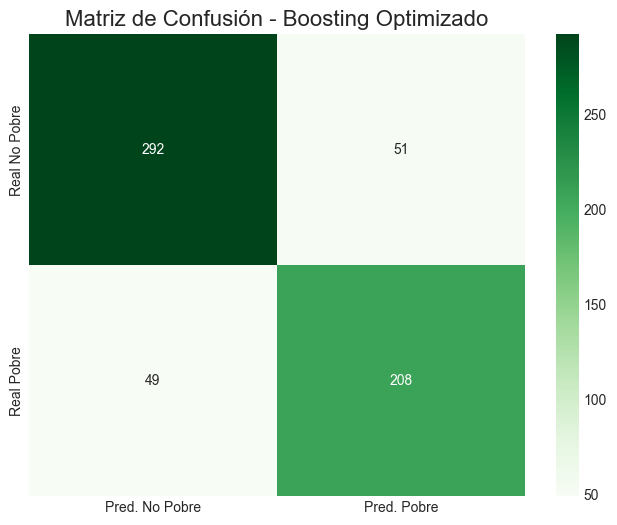

In [13]:
# Matriz de Confusión del modelo optimizado
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Pred. No Pobre', 'Pred. Pobre'],
            yticklabels=['Real No Pobre', 'Real Pobre'])
plt.title('Matriz de Confusión - Boosting Optimizado', fontsize=16)
plt.savefig(os.path.join(folder_name, '3_matriz_confusion_optimizado_boosting.png'))
plt.show()

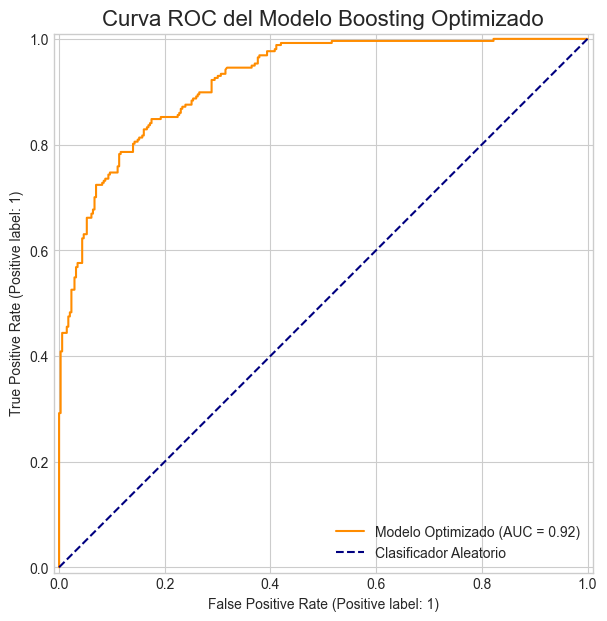

In [14]:
# Curva ROC del modelo optimizado
fig, ax = plt.subplots(figsize=(8, 7))
RocCurveDisplay.from_estimator(
    best_model, X_test, y_test, ax=ax, name='Modelo Optimizado', color='darkorange'
)
ax.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Clasificador Aleatorio')
ax.set_title('Curva ROC del Modelo Boosting Optimizado', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(os.path.join(folder_name, '4_curva_roc_optimizado_boosting.png'))
plt.show()

## 🔍 8. Interpretación del Modelo (Feature Importance y SHAP)

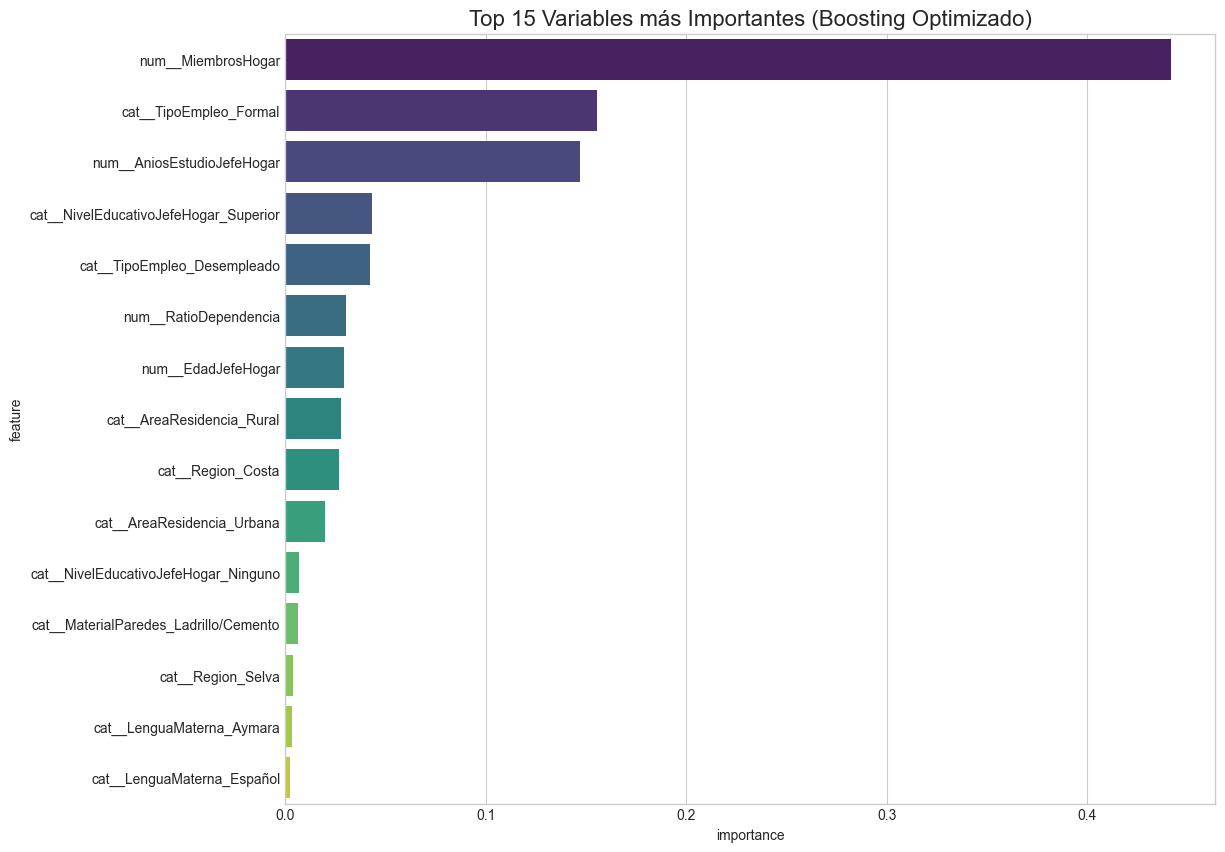

In [15]:
# Extraer importancia de variables del modelo optimizado
preprocessor_best = best_model.named_steps['preprocessor']
classifier_best = best_model.named_steps['classifier']

try:
    feature_names_out = preprocessor_best.get_feature_names_out()
except AttributeError:
    ohe_feature_names = preprocessor_best.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names_out = list(numerical_cols) + list(ohe_feature_names)

importances = classifier_best.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names_out, 'importance': importances}).sort_values('importance', ascending=False)

# Visualizar las 15 variables más importantes
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Variables más Importantes (Boosting Optimizado)', fontsize=16)
plt.savefig(os.path.join(folder_name, '5_importancia_variables_boosting.png'))
plt.show()

### Interpretación Avanzada con SHAP

Generando el gráfico SHAP summary plot...

Mostrando el gráfico...


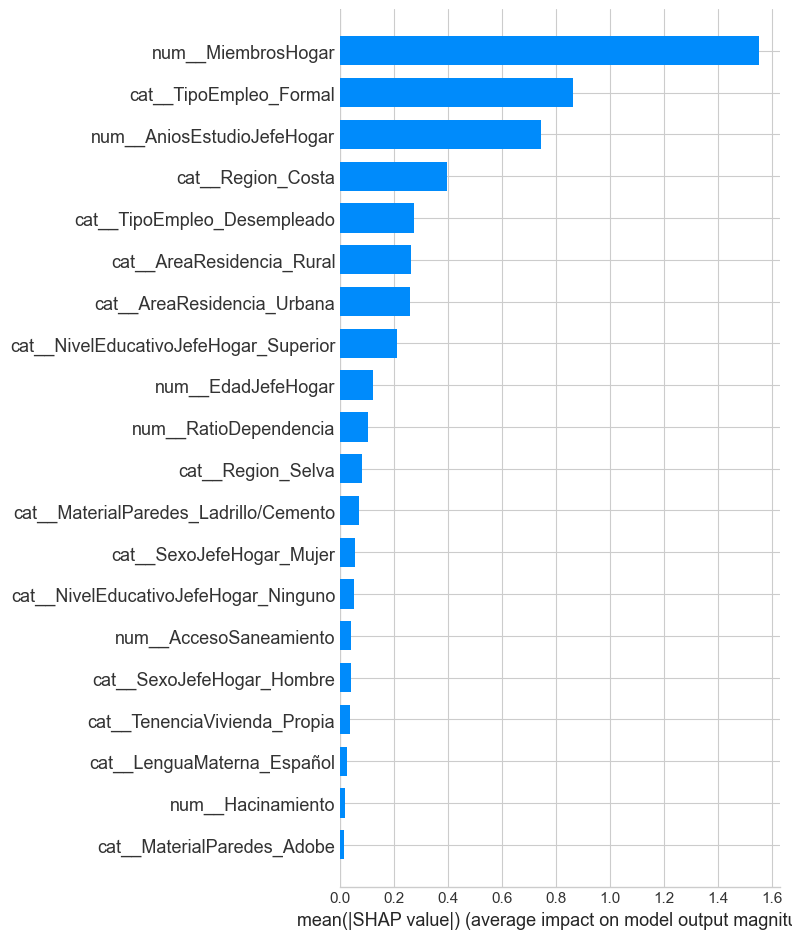

In [16]:
print("Generando el gráfico SHAP summary plot...")

X_test_transformed = preprocessor_best.transform(X_test)
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

explainer = shap.TreeExplainer(classifier_best)
shap_explanation = explainer(X_test_transformed)

print("\nMostrando el gráfico...")
shap.summary_plot(
    shap_explanation, 
    features=X_test_transformed, 
    feature_names=feature_names_out, 
    show=False,
    plot_type='bar' # Para Gradient Boosting, 'bar' es una buena opción inicial
)
plt.savefig(os.path.join(folder_name, '6_shap_summary_plot_boosting.png'), bbox_inches='tight')
plt.show()

## 🔚 9. Conclusión General

En este ejercicio, hemos construido, evaluado y optimizado con éxito un modelo `GradientBoostingClassifier`. La optimización de hiperparámetros mediante `GridSearchCV` permitió mejorar la exactitud del modelo base. Los análisis de importancia de variables y SHAP confirmaron que los principales predictores de la pobreza son factores estructurales como la demografía del hogar, el nivel educativo y el tipo de empleo, validando la capacidad del modelo para capturar relaciones socioeconómicas complejas.